# Object masks in images from prompts with SAM 2

Reference https://github.com/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb

Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg


    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-d4xem9m9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-d4xem9m9
  Resolved https://github.com/facebookresearch/sam2.git to commit c98aa6bea377d5c000cdc80197ce402dbf5304dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

# SAM for dataset

## Selecting objects with SAM 2

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the directory paths
train_dir = '/content/drive/MyDrive/CV/project/archive/train'
test_dir = '/content/drive/MyDrive/CV/project/archive/test'
val_dir = '/content/drive/MyDrive/CV/project/archive/valid'

train_annotation_file = '/content/drive/MyDrive/CV/project/archive/train/_annotations.coco.json'
test_annotation_file = '/content/drive/MyDrive/CV/project/archive/test/_annotations.coco.json'
val_annotation_file = '/content/drive/MyDrive/CV/project/archive/valid/_annotations.coco.json'


# Load COCO annotations
coco_train = COCO(train_annotation_file)
coco_test = COCO(test_annotation_file)
coco_val = COCO(val_annotation_file)

# Function to create binary masks from COCO annotations
def create_mask(image_id, coco, height, width):
    coords = []
    mask = np.zeros((height, width), dtype=np.uint8)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg).reshape((int(len(seg) / 2), 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], (height, width))
            mask[rr, cc] = 1
            cd = np.mean(poly, axis=0)
            coords.append(cd)
    # print(coords)
    middle_coord = np.mean(coords, axis=0)
    # print(coords, middle_coord)
    return mask, middle_coord

# Function to load images and masks
def load_images_and_masks(data_dir, coco, img_height=256, img_width=256):
    image_list = []
    mask_list = []
    coord_list = []
    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])
        img = Image.open(img_path)
        img = np.array(img.convert("RGB"))
        if img is not None:
            # img = cv2.resize(img, (img_width, img_height))
            # img = img / 255.0  # Normalize to [0, 1]
            mask, coord = create_mask(img_id, coco, img_info['height'], img_info['width'])
            # mask = cv2.resize(mask, (img_width, img_height))
            mask = np.expand_dims(mask, axis=-1)
            image_list.append(img)
            mask_list.append(mask)
            coord_list.append(coord)
    return np.array(image_list), np.array(mask_list), np.array(coord_list)

# Load datasets
# X_train, Y_train = load_images_and_masks(train_dir, coco_train)
# X_val, Y_val = load_images_and_masks(val_dir, coco_val)
X_test, Y_test, coord_test = load_images_and_masks(test_dir, coco_test)

# Ensure masks are binary
# Y_train[Y_train > 0.5] = 1
# Y_train[Y_train <= 0.5] = 0

# Y_val[Y_val > 0.5] = 1
# Y_val[Y_val <= 0.5] = 0

Y_test[Y_test > 0.5] = 1
Y_test[Y_test <= 0.5] = 0

# # Images and ground truth masks for training set
# images_train = X_train
# ground_truth_masks_train = Y_train

# Images and ground truth masks for validation set
# images_val = X_val
# ground_truth_masks_val = Y_val

# Images and ground truth masks for test set
images_test = X_test
ground_truth_masks_test = Y_test

loading annotations into memory...
Done (t=8.22s)
creating index...
index created!
loading annotations into memory...
Done (t=2.43s)
creating index...
index created!
loading annotations into memory...
Done (t=2.01s)
creating index...
index created!


## Display Example

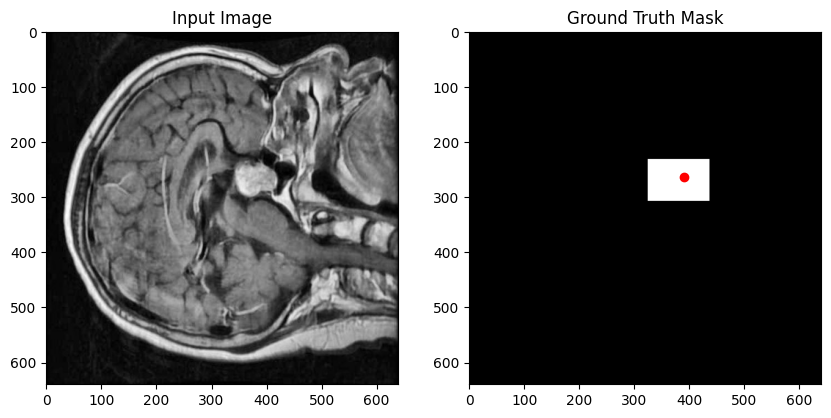

In [ ]:
# Example: Displaying an image and its corresponding ground truth mask, and coord to find the mask
plt.figure(figsize=(10, 5))

# Display an image
plt.subplot(1, 2, 1)
plt.imshow(images_test[0])
plt.title('Input Image')

# Display its corresponding ground truth mask
plt.subplot(1, 2, 2)
plt.imshow(ground_truth_masks_test[0].squeeze(), cmap='gray')
plt.scatter(coord_test[0][0], coord_test[1][0], color='red', label=f'Point ({coord_test[0][0]}, {coord_test[1][0]})')
plt.title('Ground Truth Mask')

plt.show()

In [ ]:
# Assuming you have a list of ground truth masks and images
ground_truth_masks = ground_truth_masks_test  # List or tensor of ground truth masks
images = images_test              # List or tensor of input images
coord = coord_test

# Generate random point coordinates and labels (for simplicity)
# Example: Set one point in the center of each image and label it as foreground (label = 1)
def generate_dummy_points(image):
    height, width, _ = image.shape
    point_coords = np.array([[height // 2, width // 2]])  # One point in the center
    point_labels = np.array([1])  # Label: 1 for foreground
    return point_coords, point_labels

# Predict masks using the SAM2ImagePredictor
predicted_masks = []
i = 0
for image,cd in zip(images, coord):
    predictor.set_image(image)
    point_coords, point_labels = np.array([cd]), np.array([1])
    if i%10==0:
        print(f"now process image {i}")
    predicted_mask, scores, logits = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True,)
    sorted_ind = np.argsort(scores)[::-1]
    predicted_mask = predicted_mask[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    predicted_masks.append(predicted_mask[0])
    i+=1


# Function to calculate IoU between two masks
def calculate_iou(pred_mask, gt_mask):

    # Convert to binary mask (if needed)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Ensure the ground truth mask is binary and 2D
    gt_mask = gt_mask.squeeze()  # Remove extra dimensions

    # Now calculate IoU
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0


# Calculate IoU for each image in the batch
batch_ious = []
for pred_mask, gt_mask in zip(predicted_masks, ground_truth_masks):
    # print(pred_mask.shape)
    # print(gt_mask.shape)
    iou = calculate_iou(pred_mask, gt_mask)
    batch_ious.append(iou)

# Average IoU for the batch
average_iou = np.mean(batch_ious)
print(f"Average IoU: {average_iou:.4f}")

now process image 0
now process image 10
now process image 20
now process image 30
now process image 40
now process image 50
now process image 60
now process image 70
now process image 80
now process image 90
now process image 100
now process image 110
now process image 120
now process image 130
now process image 140
now process image 150
now process image 160
now process image 170
now process image 180
now process image 190
now process image 200
now process image 210
Average IoU: 0.3149


## Plot example

In [ ]:
example_image = images[0]
predictor.set_image(example_image)
input_point = np.array([coord_test[0]])
input_label = np.array([1])

To select, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

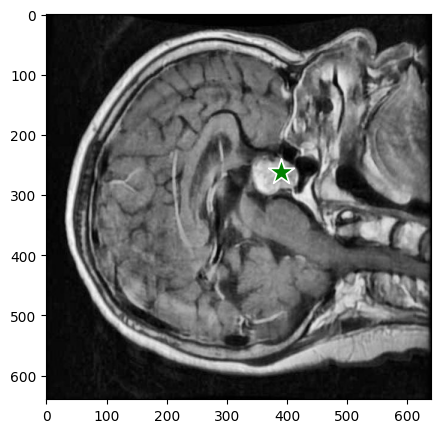

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(example_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


Predict with `SAM2ImagePredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 640, 640)

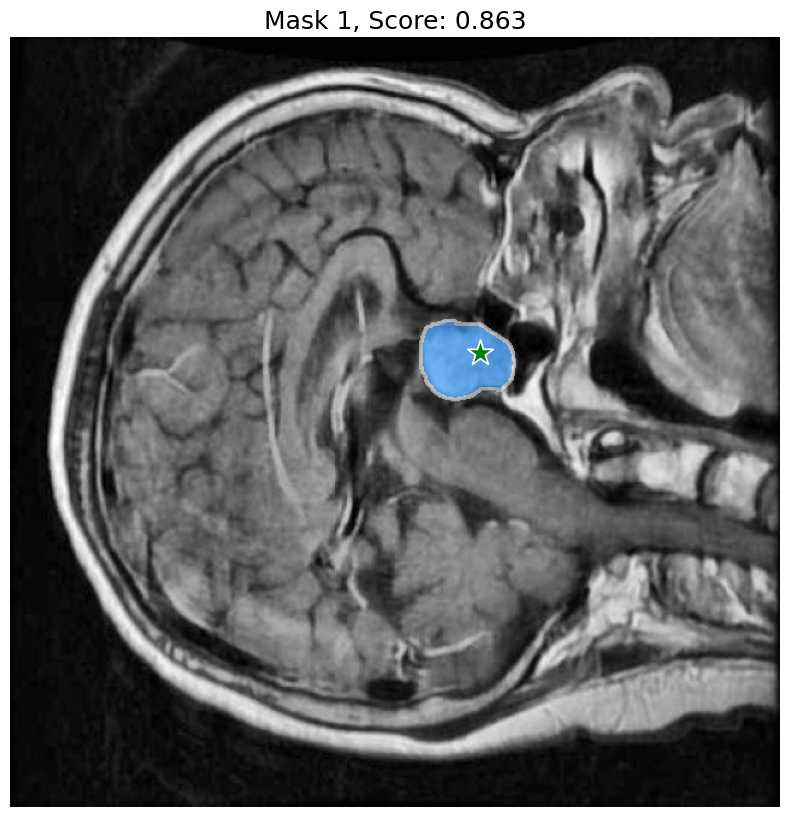

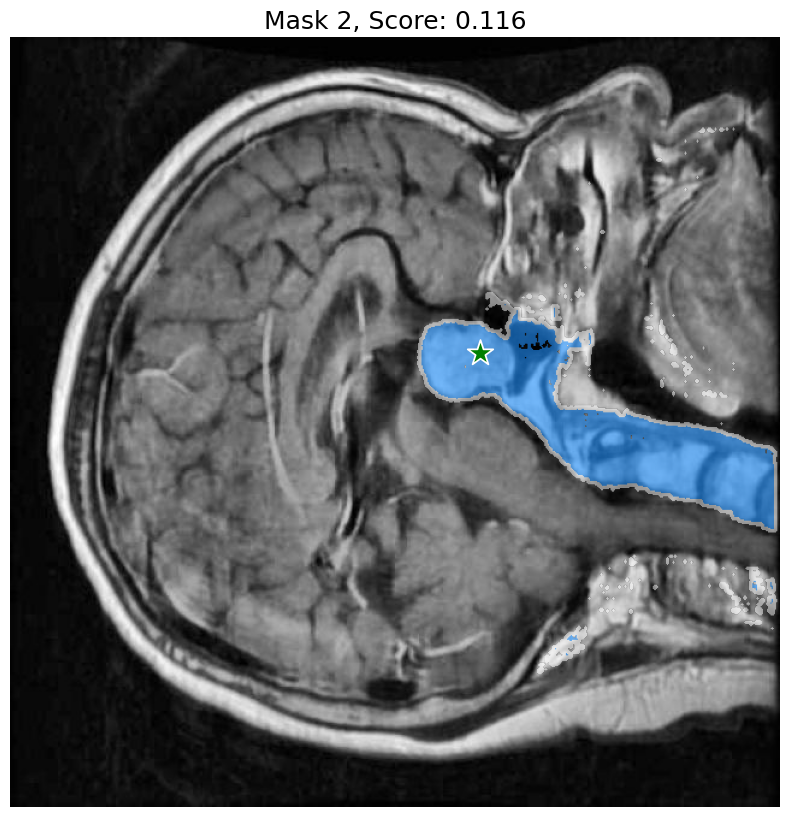

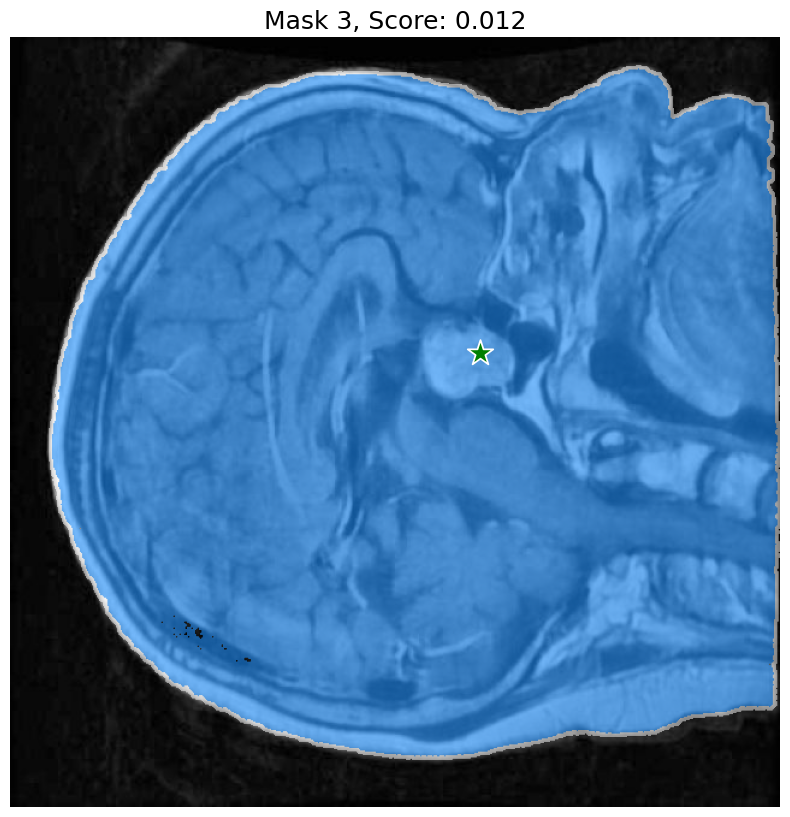

In [ ]:
show_masks(example_image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)